# Day 14: Regolith Reservoir

The distress signal leads you to a giant waterfall! Actually, hang on - the signal seems like it's coming from the waterfall itself, and that doesn't make any sense. However, you do notice a little path that leads behind the waterfall.

Correction: the distress signal leads you behind a giant waterfall! There seems to be a large cave system here, and the signal definitely leads further inside.

As you begin to make your way deeper underground, you feel the ground rumble for a moment. Sand begins pouring into the cave! If you don't quickly figure out where the sand is going, you could quickly become trapped!

Fortunately, your familiarity with analyzing the path of falling material will come in handy here. You scan a two-dimensional vertical slice of the cave above you (your puzzle input) and discover that it is mostly air with structures made of rock.

Your scan traces the path of each solid rock structure and reports the x,y coordinates that form the shape of the path, where x represents distance to the right and y represents distance down. Each path appears as a single line of text in your scan. After the first point of each path, each point indicates the end of a straight horizontal or vertical line to be drawn from the previous point. For example:

```
498,4 -> 498,6 -> 496,6
503,4 -> 502,4 -> 502,9 -> 494,9
```

This scan means that there are two paths of rock; the first path consists of two straight lines, and the second path consists of three straight lines. (Specifically, the first path consists of a line of rock from 498,4 through 498,6 and another line of rock from 498,6 through 496,6.)

In [3]:
EXAMPLE = """
498,4 -> 498,6 -> 496,6
503,4 -> 502,4 -> 502,9 -> 494,9"""

In [344]:
ROCK = "#"
SAND = "o"
AIR = "."
START = "+"
START_POS = (500, 0)

def read_puzzle(s):
    m = {START_POS: START}
    for line in s.splitlines():
        parts = line.split(" -> ")
        for p0, p1 in zip(parts, parts[1:]):
            insert_rocks(m, p0, p1)
    return m

def pm_range(n):
    # The +1 is so that in the case of x0 == x1 we get dx in [0]
    if n >= 0:
        return range(n + 1)
    else:
        return range(0, n - 1, -1)
            
def insert_rocks(m, p0, p1):
    x0, y0 = [int(s) for s in p0.split(",")]
    x1, y1 = [int(s) for s in p1.split(",")]
    # This double loop gives only the correct result if there are
    # no diagonal paths. 
    for dx in pm_range(x1 - x0):
        for dy in pm_range(y1 - y0):
            m[x0 + dx, y0 + dy] = ROCK

In [345]:
class Cave:
    def __init__(self, d):
        self.d = d
        self._dims = ((self._xmin, self._xmax), (self._ymin, self._ymax)) = self.dimensions()
        
    def get(self, pos):
        return self.d.get(pos, AIR)
    
    def set(self, pos, val):
        assert self.contains(pos)
        self.d[pos] = val
    
    def contains(self, pos):
        """See if pos is inside cave.
        """
        x, y = pos
        return (self._ymin <= y <= self._ymax) and (self._xmin <= x <= self._xmax)
        
    def dimensions(self):
        xs, ys = zip(*self.d.keys()) # thanks to https://stackoverflow.com/a/19343/20773725
        ymin, ymax = min(ys), max(ys)
        xmin, xmax = min(xs), max(xs)
        return ((xmin, xmax), (ymin, ymax))

In [346]:
m = Cave(read_puzzle(EXAMPLE))

In [347]:
def print_maze(m):
    ((xmin, xmax), (ymin, ymax)) = m.dimensions()
    for y in range(ymin, ymax + 1):
        for x in range(xmin, xmax + 1):
            val = m.get((x, y))
            if val == ROCK:
                print("#", end="")
            elif val == SAND:
                print("o", end="")
            elif val == START:
                print("+", end="")                
            else:
                print(".", end="")
        print()

In [348]:
print_maze(m)

......+...
..........
..........
..........
....#...##
....#...#.
..###...#.
........#.
........#.
#########.


The sand is pouring into the cave from point 500,0.

Drawing rock as #, air as ., and the source of the sand as +, this becomes:

```
  4     5  5
  9     0  0
  4     0  3
0 ......+...
1 ..........
2 ..........
3 ..........
4 ....#...##
5 ....#...#.
6 ..###...#.
7 ........#.
8 ........#.
9 #########.
```

Sand is produced one unit at a time, and the next unit of sand is not produced until the previous unit of sand comes to rest. A unit of sand is large enough to fill one tile of air in your scan.

A unit of sand always falls down one step if possible. If the tile immediately below is blocked (by rock or sand), the unit of sand attempts to instead move diagonally one step down and to the left. If that tile is blocked, the unit of sand attempts to instead move diagonally one step down and to the right. Sand keeps moving as long as it is able to do so, at each step trying to move down, then down-left, then down-right. If all three possible destinations are blocked, the unit of sand comes to rest and no longer moves, at which point the next unit of sand is created back at the source.

In [349]:
def fall_sand(m):
    """One unit of sand starts falling from START_POS.
    Modifies *m*.
    Returns final position of unit of sand if it could be placed.
    None otherwise.
    """
    (y, x) = START_POS
    while True:
        # Try all three directions
        for p in [(y, x+1), (y-1, x+1), (y+1, x+1)]:
            val = m.get(p)
            if not m.contains(p):
                # outside of cave this choice is taken and the unit enters the void
                break
            elif val in (AIR, START):
                # Valid move -> try next round
                break
            elif val in (ROCK, SAND):
                # try next move
                continue
            else:
                raise Exception("What happens at (%d, %d)?" % (y, x))

        if not m.contains(p):
            return None
        elif m.get(p) == AIR:
            # Valid move -> try next round
            (y, x) = p
            continue
        else:
            # Could not find a valid move. Deposit unit of sand at last pos
            m.set((y, x), SAND)
            return (y, x)

So, drawing sand that has come to rest as o, the first unit of sand simply falls straight down and then stops:

```
......+...
..........
..........
..........
....#...##
....#...#.
..###...#.
........#.
......o.#.
#########.
```

The second unit of sand then falls straight down, lands on the first one, and then comes to rest to its left:

```
......+...
..........
..........
..........
....#...##
....#...#.
..###...#.
........#.
.....oo.#.
#########.
```

After a total of five units of sand have come to rest, they form this pattern:

```
......+...
..........
..........
..........
....#...##
....#...#.
..###...#.
......o.#.
....oooo#.
#########.
```

After a total of 22 units of sand:

```
......+...
..........
......o...
.....ooo..
....#ooo##
....#ooo#.
..###ooo#.
....oooo#.
...ooooo#.
#########.
```

In [350]:
while fall_sand(m):
    pass

print_maze(m)

......+...
..........
......o...
.....ooo..
....#ooo##
...o#ooo#.
..###ooo#.
....oooo#.
.o.ooooo#.
#########.


Finally, only two more units of sand can possibly come to rest:

```
......+...
..........
......o...
.....ooo..
....#ooo##
...o#ooo#.
..###ooo#.
....oooo#.
.o.ooooo#.
#########.
```

Once all 24 units of sand shown above have come to rest, all further sand flows out the bottom, falling into the endless void. Just for fun, the path any new sand takes before falling forever is shown here with ~:

```
.......+...
.......~...
......~o...
.....~ooo..
....~#ooo##
...~o#ooo#.
..~###ooo#.
..~..oooo#.
.~o.ooooo#.
~#########.
~..........
~..........
~..........
```

Using your scan, simulate the falling sand. How many units of sand come to rest before sand starts flowing into the abyss below?


In [351]:
len([x for x in m.d.values() if x == SAND])

24

Putting this all in one function:

In [352]:
def part1(s):
    m = Cave(read_puzzle(s))
    while fall_sand(m):
        pass

    print_maze(m)
    return len([x for x in m.d.values() if x == SAND])

In [353]:
part1(EXAMPLE)

......+...
..........
......o...
.....ooo..
....#ooo##
...o#ooo#.
..###ooo#.
....oooo#.
.o.ooooo#.
#########.


24

In [354]:
with open("input") as f:
    input_maze = f.read()

In [355]:
part1(input_maze)

...........................+...........................
.......................................................
.......................................................
.......................................................
.......................................................
.......................................................
.......................................................
.......................................................
.......................................................
.......................................................
...........................o...........................
..........................ooo..........................
.........................ooooo.........................
........................#ooo#oo........................
........................#ooo#ooo.......................
........................#ooo#oooo......................
.......................o#ooo#ooooo.....................
......................###ooo#########...........

618

## --- Part Two ---

You realize you misread the scan. There isn't an endless void at the bottom of the scan - there's floor, and you're standing on it!

You don't have time to scan the floor, so assume the floor is an infinite horizontal line with a y coordinate equal to two plus the highest y coordinate of any point in your scan.

In the example above, the highest y coordinate of any point is 9, and so the floor is at y=11. (This is as if your scan contained one extra rock path like -infinity,11 -> infinity,11.) With the added floor, the example above now looks like this:

```
        ...........+........
        ....................
        ....................
        ....................
        .........#...##.....
        .........#...#......
        .......###...#......
        .............#......
        .............#......
        .....#########......
        ....................
<-- etc #################### etc -->
```

To find somewhere safe to stand, you'll need to simulate falling sand until a unit of sand comes to rest at 500,0, blocking the source entirely and stopping the flow of sand into the cave. 

In [387]:
class Cave2(Cave):
    bottom = None
    
    def __init__(self, d):
        super().__init__(d)
        self.bottom = self._ymax + 2
        
    def get(self, pos):
        x, y = pos
        if y >= self.bottom:
            return ROCK
        else:
            return super().get(pos)
        
    def contains(self, pos):
        return True
    
    def dimensions(self):
        ((xmin, xmax), (ymin, ymax)) = super().dimensions()
        # this is a bit dirty...
        if self.bottom:
            return ((xmin-2, xmax+2), (ymin, ymax+1))
        else:
            return ((xmin, xmax), (ymin, ymax))

In [398]:
def part2(s, show=True):
    m = Cave2(read_puzzle(s))
    while True:
        p = fall_sand(m)
        if p == START_POS:
            break

    if show:
        print_maze(m)
    return len([x for x in m.d.values() if x == SAND]), m

In the example above, the situation finally looks like this after 93 units of sand come to rest:

```
............o............
...........ooo...........
..........ooooo..........
.........ooooooo.........
........oo#ooo##o........
.......ooo#ooo#ooo.......
......oo###ooo#oooo......
.....oooo.oooo#ooooo.....
....oooooooooo#oooooo....
...ooo#########ooooooo...
..ooooo.......ooooooooo..
#########################
```

Using your scan, simulate the falling sand until the source of the sand becomes blocked. How many units of sand come to rest?

In [407]:
part2(EXAMPLE)

............o............
...........ooo...........
..........ooooo..........
.........ooooooo.........
........oo#ooo##o........
.......ooo#ooo#ooo.......
......oo###ooo#oooo......
.....oooo.oooo#ooooo.....
....oooooooooo#oooooo....
...ooo#########ooooooo...
..ooooo.......ooooooooo..
#########################


(93, <__main__.Cave2 at 0x7fc4174ae760>)

In [401]:
part2(input_maze, show=False)

(26358, <__main__.Cave2 at 0x7fc4152cc2e0>)

## Pretty Output

Let's create a "nice" animation using numpy and matplotlib.

(This is all quick and dirty)

In [432]:
import numpy as np

In [435]:
import matplotlib.pyplot as plt

In [493]:
def sand_animation(s, every=18):
    m = Cave2(read_puzzle(s))
    n = 0
    frames = [dict(m.d)]
    while True:
        n += 1
        p = fall_sand(m)
        if n % every == 0:
            # save a frame
            frames.append(dict(m.d))
        if p == START_POS:
            break
    frames.append(m.d)
    return frames, m

In [494]:
res, final = sand_animation(input_maze)

In [495]:
((x0, x1), (y0, y1)) = final.dimensions()
np_res = []
for d in res:
    np_m = np.zeros((x1-x0, y1-y0), dtype=int)
    for ((x, y), val) in d.items():
        if val == ROCK:
            np_m[x-x0, y-y0] = 1
        elif val == SAND:
            np_m[x-x0, y-y0] = 2
    np_res.append(np_m)

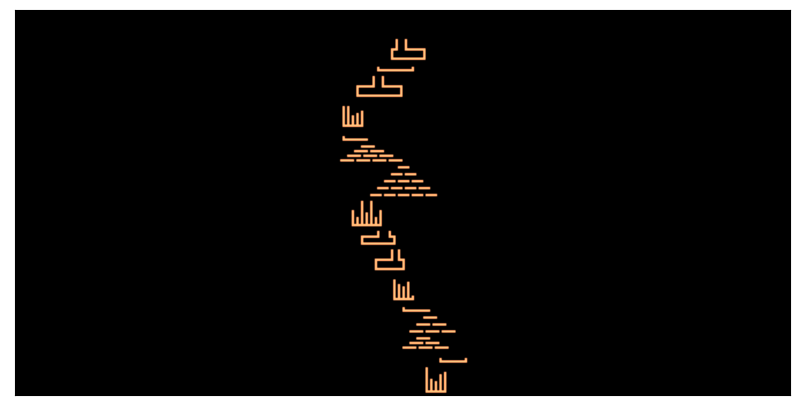

In [501]:
np_m = np_res[0]
plt.figure(figsize=(10,6))
plt.imshow(np_m.T, origin='upper', cmap='copper', aspect='equal')

#get current axes
ax = plt.gca()

#hide x-axis
ax.get_xaxis().set_visible(False)

#hide y-axis 
ax.get_yaxis().set_visible(False)

In [498]:
from matplotlib import animation

class SandAnimation:
    def __init__(self, np_res, frames, cmap='copper', figsize=(6,4)):
        self.fig = plt.figure(figsize=figsize)
        self.ax1 = ax1 = plt.subplot(1,1,1)
        self.cmap = cmap
        self.image = ax1.imshow(np_res[0].T, origin='upper', cmap='copper', aspect='equal')
        ax1.get_xaxis().set_visible(False)
        ax1.get_yaxis().set_visible(False)
        self.data = np_res
        self.frames = frames

    def init_anmimation(self):
        self.image.set_data(self.data[0].T)
        return self.image,

    def get_frame(self, i):
        self.image.set_data(self.data[i].T)
        return self.image,
    
    def animation(self):
        anim = animation.FuncAnimation(self.fig, self.get_frame, init_func=self.init_anmimation,
                                       frames=self.frames, interval=50, blit=True)
        return anim
    
    def save_mp4(self, filename):
        ffwriter = animation.FFMpegWriter(fps=24, extra_args=['-vcodec', 'libx264'])
        anim = self.animation()
        anim.save(filename, dpi=300, writer=ffwriter)
        plt.close()   # to prevent the last frame from showing in notebook

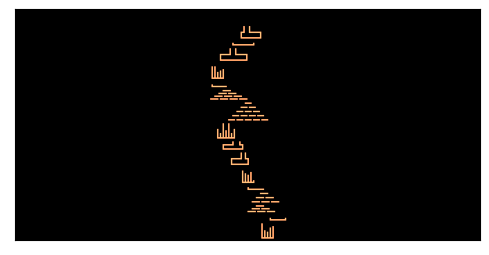

In [499]:
anim = SandAnimation(np_res, len(np_res))

In [500]:
anim.save_mp4("test.mp4")